#Dissipative Driven Entanglement Notebook
Author: Eugene Dumitrescu

In this notebook we (loosely) follow the prescription of Refs[1,2] to simulate the dynamical entanglement of QD systems coupled to a quantum environment. The approach taken is based on cavity QED, however our aim is to replace the cavity with a plasmonic reservoir.

### References
* [M. Otten, R. A. Shah, N. F. Scherer, M. Min, M. Pelton, and S. K. Gray, Phys. Rev. B 92, 125432 (2015)](http://journals.aps.org/prb/abstract/10.1103/PhysRevB.92.125432)
* [Dissipation-driven entanglement between qubits mediated by plasmonic nanoantennas](http://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.235413)


# Entanglement in the dark

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from qutip import *

# operators acting on the composite spin-boson Hilbert space
def I(N,M):
    """Identity"""
    oplist = [qeye(2)] * N
    oplist.append(qeye(M))
    return tensor(oplist)

# spin operators
def sx(i, N, M):
    """Pauli X on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmax()
    oplist.append(qeye(M))
    return tensor(oplist)

def sy(i, N, M):
    """Pauli Y on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmay()
    oplist.append(qeye(M))
    return tensor(oplist)

def sz(i, N, M):
    """Pauli Z on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmaz()
    oplist.append(qeye(M))
    return tensor(oplist)

def sm(i, N, M):
    """destroy quanta on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmam()
    oplist.append(qeye(M))
    return tensor(oplist)

def sp(i, N, M):
    """create quanta on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmap()
    oplist.append(qeye(M))
    return tensor(oplist)

def d(i,N,M):
    """dipole operator for ith spin"""
    return sp(i, N, M) + sm(i, N, M)

# plasmon / EM mode operators
def a(N, M):
    """bosonic annihiliation operator"""
    oplist = [qeye(2)] * N
    oplist.append(destroy(M))
    return tensor(oplist)

def n_a(N,M):
    """bosonic number operator"""
    return a(N,M).dag() * a(N,M)

def d_a(N,M):
    """bosonic dipole operator"""
    return a(N,M).dag() + a(N,M)

# spin subspace projection operators 
def P_S(N,M):
    """Symmetric |s = 1, m_l = 0> subspace projector"""
    return .25 * (I(N,M) - sz(0,N,M) * sz(1,N,M) + sx(0,N,M) * sx(1,N,M) + sy(0,N,M) * sy(1,N,M))

def P_A(N,M):
    """Anti-symmetric |s = 0, m_l = 0> subspace projector"""
    return .25 * (I(N,M) - sz(0,N,M) * sz(1,N,M) - sx(0,N,M) * sx(1,N,M) - sy(0,N,M) * sy(1,N,M))

def P_pp(N,M):
    """|++> subspace projector """
    return np.prod([sp(i,N,M) * sm(i,N,M)  for i in range(N)])

def P_mm(N,M):
    """|--> subspace projector """
    return np.prod([sm(i,N,M) * sp(i,N,M)  for i in range(N)])


## Hamiltonian and Model

Our model Hamiltonian for a N two levels systems (TLS) interacting with a bosonic reservoir is 
<center> $H = H_0 + H_{int} + H_{drv}$ </center>
where the individual, interacting, and driving components of the Hamiltonian are given by 
<center>
$\displaystyle H_0 = - \omega_0 \sum_{i=1}^N \sigma_z^{(i)} + \omega_c a^\dagger a$
</center>
<center>
$\displaystyle H_{int} = - \sum_{i}^N g_i (\sigma^{+}a + \sigma^{-}a^\dagger)$
</center>
<center>
$\displaystyle H_{drv} = - \sum_{i}^N \Omega_i \hat{d}_i + \Omega_a \hat{d}_a$
</center>
We have used the EM field and TLS dipole operators $\hat{d}_i = \sigma^+_{(i)}+\sigma^-_{(i)}$ and $\hat{d}_a = a + a^\dagger$  in the driving term and we have also applied the rotating wave approximation.

In [154]:
N = 2          # Number of spin 1/2's
M = 3          # Number of cavity modes
lam = 1        # constant that all other constants are given in terms of

ws = [-0.025, 0.1, 0.0]           # frequency/level spacing of each individual system
gs = [lam * 0.1, lam * 0.1]       # position dependent couplings
ds = [-0.101, -0.0888, 0]         # driving strengths qb0,1, bosons 

def Ham(ws,gs,ds):
    """ Define the Hamiltonian as a function of the above parameters """
    H_0   = sum(ws[i] * sp(i,N,M) * sm(i,N,M) for i in range(N)) + ws[N] * n_a(N,M)
    H_RWA = sum(gs[i] * (a(N,M) * sp(i,N,M) + a(N,M).dag() * sm(i,N,M)) for i in range(N))
    H_DRV = sum(ds[i] * d(i,N,M) for i in range(N)) + ds[N] * d_a(N,M)
    return H_0 - H_RWA - H_DRV

# Lindblad dissipation parameters
kap   = 1 * lam           # cavity relaxation rate
gam   = 0 * 1 * kap/1e8   # atom relaxation rate
gdph  = 0 * kap/1e6       # atom dephasing rate 
n_th  = 0.0               # thermal cavity occupation number 

def cops(kappa, gamma, deph, n_th):
    """
    Define collapse operators for Lindblad master equation
    
    Parameters
    ----------
    kappa: cavity relaxation rate,  ~ 500 THz ~ 2 eV
    gamma: emitter relaxation rate, ~ 10 MHz ~ 1mueV
    gdph: emitter dephasing rate,   ~ same as relaxation rate
    n_th: temperature for entire system, gives excitation rate

    Returns
    -------
    c_ops: list of collapse operators
    """
    c_ops = []
    for i in range(2):
        rate = np.sqrt(gamma * (1 + n_th))
        if rate > 0.0:
            c_ops.append(rate * sm(i,N,M))        # relaxation
        rate = gamma * n_th
        if rate > 0.0:
            c_ops.append(rate * sm(i,N,M).dag())  # excitation
        c_ops.append(np.sqrt(deph) * sz(i,N,M))   # dephasing  
    rate = np.sqrt(kappa * (n_th + 1))
    if rate > 0: 
        c_ops.append(rate * a(N,M))
    rate = np.sqrt(kappa * (n_th))
    if rate > 0: 
        c_ops.append(rate * a(N,M).dag())
    return c_ops

In [114]:
# # Derive effective hamiltonian for the reduced spin sub-systems by tracing over the plasmonic degrees of freedom
# w_range = np.linspace(0.0,2.05,200)
# wcs = [[ws[0], ws[1], w] for w in w_range]

# # diagonal elements of Ham as a function of parameter range
# zzs = [ptrace(Ham(w,gs,ds),range(N))[0,0] for w in wcs]
# oos = [ptrace(Ham(w,gs,ds),range(N))[1,1] for w in wcs]
# tts = [ptrace(Ham(w,gs,ds),range(N))[2,2] for w in wcs]
# hhs = [ptrace(Ham(w,gs,ds),range(N))[3,3] for w in wcs]

# plt.plot(w_range, zzs,'-',  label = '0')
# plt.plot(w_range, oos,'--', label = '1')
# plt.plot(w_range, tts,'-',  label = '2')
# plt.plot(w_range, hhs,'-',  label = '3')
# plt.legend()
# plt.show()

# zzs==oos==tts==hhs

# # ptrace(Ham(ws,[1,100],ds),[0,1])

# Dynamical Evolution

Let us initialize system with one dot excited and the other in the ground state and allow the system to evolve dissipatively. Short lived entanglement, as measured by the concurrence, should be generated between the dots; although asymmetric couplings may be needed to realize the expected result. 


## Master Eqaution:

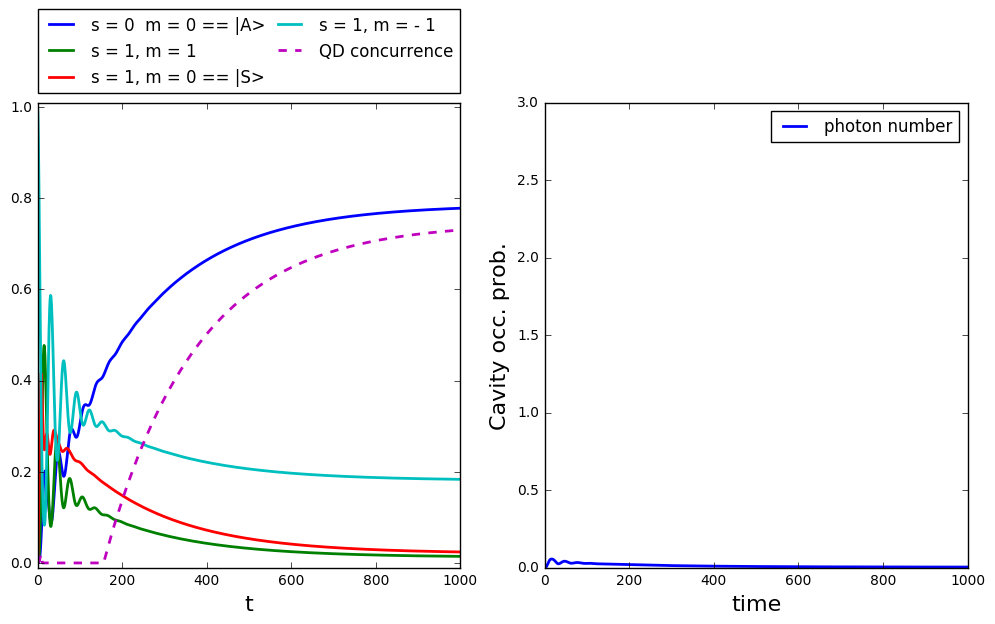

In [155]:
# Initial state
psi_0 = basis(2,1)                   # qb 1  ground state
psi_1 = basis(2,1)                   # qb 2 excited state
psi_c = basis(M,0)                   # initial fock state
psi_tot = tensor(psi_0,psi_1,psi_c)  # tensor product

# discretized time domain
tlist = np.linspace(0,1e3, 2e3)

# run dynamics solver
result = mesolve(Ham(ws,gs,ds), psi_tot, tlist, cops(kap, gam, gdph, n_th), [])

# expectation value operators: subspace occupation number projectors and concurrence
e_ops = [P_S(N,M), P_A(N,M), P_pp(N,M), P_mm(N,M), n_a(N,M)]
Ex_P_S, Ex_P_A, Ex_Ppp, Ex_Pmm, Ex_n_a = [[expect(e,st) for st in result.states] for e in e_ops]
concr = [concurrence(ptrace(st,(0,1))) for st in result.states]

#plot results
fig, axes = plt.subplots(1, 2, figsize=(12,6))

times = tlist      # renormakize time units
axes[0].plot(times, Ex_P_A, '-', linewidth=2, label="s = 0  m = 0 == |A>")
axes[0].plot(times, Ex_Ppp, '-', linewidth=2, label="s = 1, m = 1")
axes[0].plot(times, Ex_P_S, '-', linewidth=2, label="s = 1, m = 0 == |S>")
axes[0].plot(times, Ex_Pmm, '-', linewidth=2, label="s = 1, m = - 1")
axes[0].plot(times, concr , '--', linewidth=2, label="QD concurrence")
axes[0].set_ylim(-.01,1.01)
axes[0].set_xlabel("t", fontsize=16)
axes[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

axes[1].plot(times, Ex_n_a, '-', linewidth=2, label="photon number")
axes[1].set_ylim(0, M)
axes[1].set_ylabel("Cavity occ. prob.", fontsize=16)
axes[1].set_xlabel("time", fontsize=16)
axes[1].legend(loc=0)
# np.transpose([Ex_P_A, Ex_Ppp, Ex_P_S, Ex_Pmm])  # plotted data
plt.show()

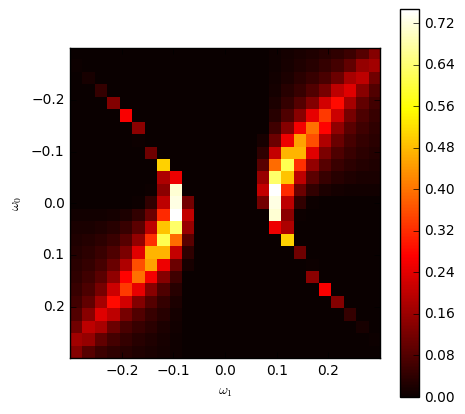

In [156]:
# Concurrence 'phase diagrams'
# as a function of detunings
N_w = 25
w_r = 0.3
w_range = np.linspace(-w_r,w_r,N_w)
rho_sss = [[steadystate(Ham([w0, w1, 0], gs, ds),
                        cops(kap, gam, gdph, n_th)) for w0 in w_range] for w1 in w_range]
concs = [[concurrence(ptrace(rho_sss[i][j],[0,1])) for i in range(N_w)] for j in range(N_w)]

fig, ax = plt.subplots(1, 1, figsize = (5,5))
plt.imshow(concs, cmap='hot', interpolation='nearest', extent=[-w_r,w_r,w_r,-w_r])
ax.set_xlabel('$\omega_1$')
ax.set_ylabel('$\omega_0$')
plt.colorbar()
plt.show()

i0,i1 = np.where(concs==np.amax(np.array(concs)))
print(i0,i1)
print(np.amax(np.array(concs)), w_range[i0[0]],w_range[i1[0]])

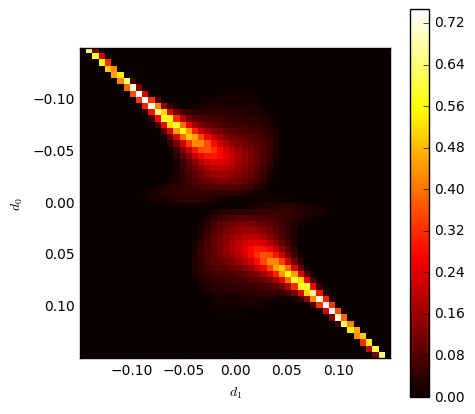

In [158]:
N_d = 50
d_r = 0.15
d_range = np.linspace(-d_r,d_r,N_d)
rho_sss = [[steadystate(Ham(ws, gs, [d0, d1, 0]),
                        cops(kap, gam, gdph, n_th)) for d0 in d_range] for d1 in d_range]
concs = [[concurrence(ptrace(rho_sss[i][j],[0,1])) for i in range(N_d)] for j in range(N_d)]

fig, ax = plt.subplots(1, 1, figsize = (5,5))
plt.imshow(concs, cmap='hot', interpolation='nearest', extent=[-d_r,d_r,d_r,-d_r])
ax.set_xlabel('$d_1$')
ax.set_ylabel('$d_0$')
plt.colorbar()
plt.show()

i0,i1 = np.where(concs==np.amax(np.array(concs)))
print(i0,i1)
print(np.amax(np.array(concs)), d_range[i0[0]],d_range[i1[0]])

In [ ]:
N_g = 50
g_r = 0.15
g_range = np.linspace(-g_r,g_r,N_g)
rho_sss = [[steadystate(Ham(ws, [g0, g1], ds),
                        cops(kap, gam, gdph, n_th)) for g0 in g_range] for g1 in g_range]
concs = [[concurrence(ptrace(rho_sss[i][j],[0,1])) for i in range(N_g)] for j in range(N_g)]

fig, ax = plt.subplots(1, 1, figsize = (5,5))
plt.imshow(concs, cmap='hot', interpolation='nearest', extent=[min(g_range),max(g_range),max(g_range),min(g_range)])
ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_0$')
plt.colorbar()
plt.show()

i0,i1 = np.where(concs==np.amax(np.array(concs)))
print(i0,i1)
print(np.amax(np.array(concs)), g_range[i0[0]],g_range[i1[0]])

In [ ]:
print('ws are ' + str(ws))
print('gs are ' + str(gs))
print('ds are ' + str(ds))